In [1]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(5):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)
    if os.path.basename(module_path) =='frame':
        break
from src.unit import Unit
from src.operators import *
import src.operators
from src.operator_base import op_type_dicts
from src.system import System
import pandas as pd
from src.analye_model import *
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# print(sys.path,module_path)
from utils.display_and_plots import *

/Users/abhimanyu/Work/DL_codes/frame/data/model


/Users/abhimanyu/Work/DL_codes/frame/src/analye_model.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(roofline_list), columns=column)


,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Bound,Compute Cycles,Memory Cycles,C/M ratio,Cycles,% of total time,Throughput (Tflops),Latency (msec),C Effcy,Roofline Throughput offchip (Tflops),Roofline Throughput onchip (Tflops)
0,GEMM,[ 1 1024 512 1024],256.000000,1073.741824,0.500000,1.000000,0.500000,2.000000,C,8192.000000,4079.861111,2.007911,8192.000000,6.901240,123.207680,0.008715,1.000000,123.207680,123.207680
1,GEMM,[ 1 1024 512 1024],256.000000,1073.741824,0.500000,1.000000,0.500000,2.000000,C,8192.000000,4079.861111,2.007911,8192.000000,6.901240,123.207680,0.008715,1.000000,123.207680,123.207680
2,GEMM,[ 1 1024 512 1024],256.000000,1073.741824,0.500000,1.000000,0.500000,2.000000,C,8192.000000,4079.861111,2.007911,8192.000000,6.901240,123.207680,0.008715,1.000000,123.207680,123.207680
3,Logit,[ 1 16 512 512 64],51.200000,536.870912,0.500000,0.500000,4.000000,5.000000,M,4096.000000,10199.652778,0.401582,10199.652778,8.592560,49.478023,0.010851,1.000000,49.478023,123.207680
4,Attend,[ 1 16 512 512 64],51.200000,536.870912,4.000000,0.500000,0.500000,5.000000,M,4096.000000,10199.652778,0.401582,10199.652778,8.592560,49.478023,0.010851,1.000000,49.478023,123.207680
5,GEMM,[ 1 1024 512 1024],256.000000,1073.741824,0.500000,1.000000,0.500000,2.000000,C,8192.000000,4079.861111,2.007911,8192.000000,6.901240,123.207680,0.008715,1.000000,123.207680,123.207680
6,GEMM,[ 1 4096 512 1024],315.076923,4294.967296,0.500000,4.000000,2.000000,6.500000,C,32768.000000,13259.548611,2.471276,32768.000000,27.604960,123.207680,0.034860,1.000000,123.207680,123.207680
7,GEMM,[ 1 1024 512 4096],315.076923,4294.967296,2.000000,4.000000,0.500000,6.500000,C,32768.000000,13259.548611,2.471276,32768.000000,27.604960,123.207680,0.034860,1.000000,123.207680,123.207680


,Latency (msec),Cycles,Parameters (MB),On-chip Memory Footprint (MB)
0,0.13,118703.31,12.00,6.50


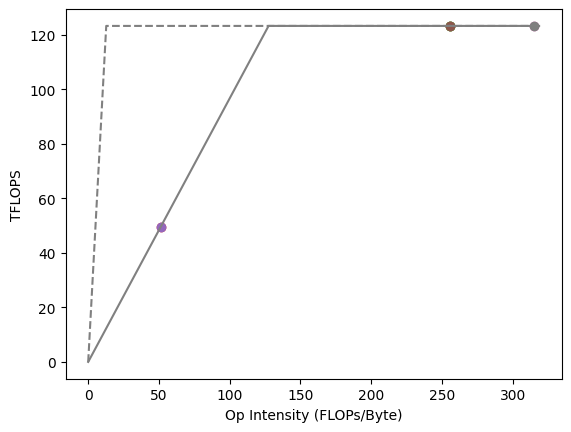

In [3]:

# model = 'vgg16'
# data_path = os.path.join(module_path,"data")

# seq_len = 256
model = 'custom_attn_vanilla'
data_path = os.path.join(module_path,"data")
model_path = os.path.join(data_path,"model")
# create_model(seq_len, name=model, data_path=data_path)
print(model_path)

batch_size = 1
unit = Unit()
system = System(unit)
model_df = get_model_df(model, system, unit, batch_size, data_path, sparse=False )
display_df(model_df)

dot_roofline(model_df, system, unit)
get_summary_table(model_df)